In [54]:
from datasets import load_dataset, get_dataset_split_names, Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from ultralytics import YOLO

# Méthodes utiles

In [55]:
def coco_to_yolo(bbox, img_w, img_h):
    """
    Method that transforms any bbox in coc format to yolo format so that 
    it can be used as input to a YOLO model
    """
    x, y, w, h = bbox
    cx = (x + w / 2) / img_w
    cy = (y + h / 2) / img_h
    w /= img_w
    h /= img_h
    return cx, cy, w, h

In [56]:
# Inspect dataset splits
get_dataset_split_names("benjamintli/SKU110k")

['train', 'validation', 'test']

In [57]:
dataset = load_dataset("benjamintli/SKU110k")
# dataset = dataset.cast_column("image", Image())

In [58]:
print(dataset['train'])

Dataset({
    features: ['image', 'objects'],
    num_rows: 8219
})


In [59]:
sample = dataset["train"][0] 
print(type(sample["image"]))  # PIL.Image.Image
print(sample["objects"].keys())

<class 'PIL.JpegImagePlugin.JpegImageFile'>
dict_keys(['bbox', 'category'])


In [60]:
sample["objects"]['bbox'][0]

[208.0, 537.0, 214.0, 277.0]

Note : ne fonctionne que si pillow est installé, si ce n'était pas le cas, il faut réinitialiser l'environnement, lui ajouter pillow et relancer tout le notebook

### Vérification visuelle du format des bbox

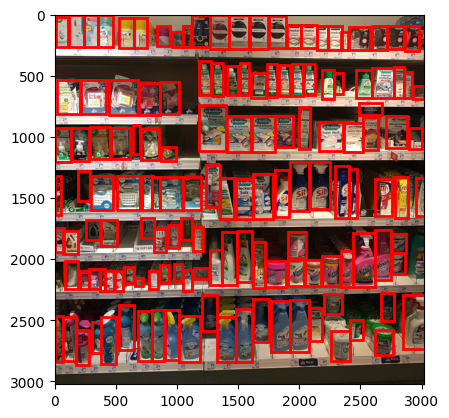

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(sample["image"])

for bbox in sample["objects"]['bbox']:

    x, y, w, h = bbox
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2,
        edgecolor="red",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.show()


Les bbox sont bien au format coco : [x_min, y_min, width, height]

# Enregistrer les données au format YOLO

In [62]:
type(dataset['train'][0]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [63]:
import os

def convert_coco_to_yolo(dataset, output_dir):
    for split in dataset.keys():
        output_image_dir = f"{output_dir}/images/{split}/"
        if not os.path.isdir(output_image_dir):
            os.makedirs(output_image_dir)
        output_labels_dir = f"{output_dir}/labels/{split}/"
        if not os.path.isdir(output_labels_dir):
            os.makedirs(output_labels_dir)
        for idx_im, image in enumerate(dataset[split]):
            im_width, im_height = image['image'].size
            image['image'].save(os.path.join(output_image_dir, f"image_{idx_im}.jpeg"))
            output_label_file = os.path.join(output_labels_dir, f"image_{idx_im}.txt")
            with open(output_label_file, 'w') as f:
                for idx_box, bbox in enumerate(image['objects']['bbox']):
                    category_id = image['objects']['category'][idx_box]
                    #transform and normalize
                    x_min, y_min, width, height = bbox
                    x_center = (x_min + width / 2) / im_width
                    y_center = (y_min + height / 2) / im_height
                    width /= im_width
                    height /= im_height
                    f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

In [64]:
convert_coco_to_yolo(dataset, 'data_yolo')

### Vérification visuelle de la transformation en YOLO

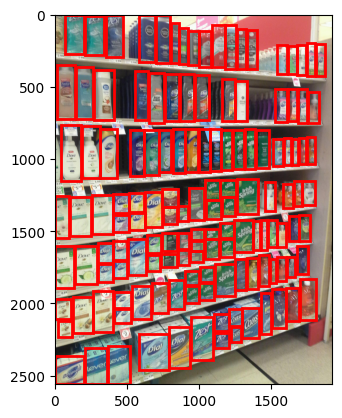

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = Image.open("data_yolo/images/train/image_1.jpeg")
w, h = img.size
fig, ax = plt.subplots(1)
ax.imshow(img)

# lines_list = []
with open("data_yolo/labels/train/image_1.txt") as f:
    lines_list = [line.rstrip('\n').split() for line in f]

for line in lines_list: 
    cls, cx, cy, bw, bh = map(float, line)
    x = (cx - bw / 2) * w
    y = (cy - bh / 2) * h
    bw *= w
    bh *= h
    ax.add_patch(
        patches.Rectangle((x, y), bw, bh, edgecolor="red", facecolor="none", linewidth=2)
    )
plt.show()


Les rectangles entourent bien les produits, la conversion est correcte.

In [65]:
model = YOLO("yolo3n.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'yolo3n.pt'